# Machine Learning Project: Flight Delay Data

In [2]:
## Import Basic libraries
import pandas as pd
import numpy as np
import warnings
import seaborn as sns

warnings.filterwarnings('ignore')

# Import flight data
flights = pd.read_csv("data/Train_with_Countries.csv")


RSEED = 42


In [3]:
import sys
!{sys.executable} -m pip install xgboost

zsh:1: no such file or directory: /Users/Yannek_1/Documents/03_Data
zsh:1: no such file or directory: AI/ds-ml-flight-delays-project/.venv/bin/python


---

# Data Inspection

#### Overview Columns
- DATOP - Date of flight
- fltid - Flight number
- DEPSTN - Departure point
- ARRSTN - Arrival point
- STD - Scheduled Time departure
- STA - Scheduled Time arrival
- STATUS - Flight status
    - ETD - Expected Time departure
    - ETA - Expected Time arrival
    - ATD - Actual Time of Departure
    - ATA - Actual Time of arrival
    - DELAY1 - Delay code 1
    - DUR1 - delay time 1
    - DELAY2 - Delay code 2
    - DUR2 - delay time 2
    - DELAY3 - Delay code 3
    - DUR3 - delay time 3
    - DELAY4 - Delay code 4
    - DUR4 - delay time 4
- AC - Aircraft Code

In [4]:
flights.head()

,ID,DATOP,FLTID,DEPSTN,DEP_COUNTRY,ARRSTN,ARR_COUNTRY,STD,STA,STATUS,AC,target
0,train_id_0,2016-01-03,TU 0712,CMN,Morocco,TUN,Tunisia,2016-01-03 10:30:00,2016-01-03 12:55:00,ATA,TU 32AIMN,260.0
1,train_id_1,2016-01-13,TU 0757,MXP,Italy,TUN,Tunisia,2016-01-13 15:05:00,2016-01-13 16:55:00,ATA,TU 31BIMO,20.0
2,train_id_2,2016-01-16,TU 0214,TUN,Tunisia,IST,Turkey,2016-01-16 04:10:00,2016-01-16 06:45:00,ATA,TU 32AIMN,0.0
3,train_id_3,2016-01-17,TU 0480,DJE,Tunisia,NTE,France,2016-01-17 14:10:00,2016-01-17 17:00:00,ATA,TU 736IOK,0.0
4,train_id_4,2016-01-17,TU 0338,TUN,Tunisia,ALG,Algeria,2016-01-17 14:30:00,2016-01-17 15:50:00,ATA,TU 320IMU,22.0


In [5]:
## Spalte für Origin-Destination Paar hinzugefügt
flights["OD"] = flights.DEPSTN + "_" + flights.ARRSTN

flights.head()

,ID,DATOP,FLTID,DEPSTN,DEP_COUNTRY,ARRSTN,ARR_COUNTRY,STD,STA,STATUS,AC,target,OD
0,train_id_0,2016-01-03,TU 0712,CMN,Morocco,TUN,Tunisia,2016-01-03 10:30:00,2016-01-03 12:55:00,ATA,TU 32AIMN,260.0,CMN_TUN
1,train_id_1,2016-01-13,TU 0757,MXP,Italy,TUN,Tunisia,2016-01-13 15:05:00,2016-01-13 16:55:00,ATA,TU 31BIMO,20.0,MXP_TUN
2,train_id_2,2016-01-16,TU 0214,TUN,Tunisia,IST,Turkey,2016-01-16 04:10:00,2016-01-16 06:45:00,ATA,TU 32AIMN,0.0,TUN_IST
3,train_id_3,2016-01-17,TU 0480,DJE,Tunisia,NTE,France,2016-01-17 14:10:00,2016-01-17 17:00:00,ATA,TU 736IOK,0.0,DJE_NTE
4,train_id_4,2016-01-17,TU 0338,TUN,Tunisia,ALG,Algeria,2016-01-17 14:30:00,2016-01-17 15:50:00,ATA,TU 320IMU,22.0,TUN_ALG


In [6]:
flights.OD.value_counts()

OD
ORY_TUN    4579
TUN_ORY    4564
TUN_TUN    4320
DJE_TUN    3645
TUN_DJE    3521
           ... 
SKG_ADB       1
ADB_TUN       1
FCO_FCO       1
TUN_SKG       1
HBE_CAI       1
Name: count, Length: 741, dtype: int64

In [7]:
flights.DEPSTN.value_counts()

DEPSTN
TUN    42522
DJE    10252
ORY     6755
MIR     5248
MRS     2845
       ...  
ADB        1
SKG        1
OTP        1
KBP        1
CTA        1
Name: count, Length: 132, dtype: int64

In [8]:
flights.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 107833 entries, 0 to 107832
Data columns (total 13 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   ID           107833 non-null  object 
 1   DATOP        107833 non-null  object 
 2   FLTID        107833 non-null  object 
 3   DEPSTN       107833 non-null  object 
 4   DEP_COUNTRY  107833 non-null  object 
 5   ARRSTN       107833 non-null  object 
 6   ARR_COUNTRY  107833 non-null  object 
 7   STD          107833 non-null  object 
 8   STA          107833 non-null  object 
 9   STATUS       107833 non-null  object 
 10  AC           107833 non-null  object 
 11  target       107833 non-null  float64
 12  OD           107833 non-null  object 
dtypes: float64(1), object(12)
memory usage: 10.7+ MB


In [9]:
# DATOP und STD direkt in datetime umwandeln
flights["DATOP"] = pd.to_datetime(flights["DATOP"], format="%Y-%m-%d", errors="coerce")
flights["STD"] = pd.to_datetime(flights["STD"], format="%Y-%m-%d %H:%M:%S", errors="coerce")

# STA enthält Uhrzeit mit Punkt statt Doppelpunkt – erst korrigieren, dann umwandeln
flights["STA_cleaned"] = flights["STA"].str.replace(".", ":", regex=False)
flights["STA"] = pd.to_datetime(flights["STA_cleaned"], format="%Y-%m-%d %H:%M:%S", errors="coerce")

# Temporäre Hilfsspalte entfernen
flights.drop(columns=["STA_cleaned"], inplace=True)

In [10]:
flights.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 107833 entries, 0 to 107832
Data columns (total 13 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   ID           107833 non-null  object        
 1   DATOP        107833 non-null  datetime64[ns]
 2   FLTID        107833 non-null  object        
 3   DEPSTN       107833 non-null  object        
 4   DEP_COUNTRY  107833 non-null  object        
 5   ARRSTN       107833 non-null  object        
 6   ARR_COUNTRY  107833 non-null  object        
 7   STD          107833 non-null  datetime64[ns]
 8   STA          107833 non-null  datetime64[ns]
 9   STATUS       107833 non-null  object        
 10  AC           107833 non-null  object        
 11  target       107833 non-null  float64       
 12  OD           107833 non-null  object        
dtypes: datetime64[ns](3), float64(1), object(9)
memory usage: 10.7+ MB


In [11]:
flights["STATUS"].value_counts()

STATUS
ATA    93679
SCH    13242
DEP      467
RTR      294
DEL      151
Name: count, dtype: int64

In [12]:
round(flights["target"].value_counts(normalize=True),4)

target
0.0       0.3540
10.0      0.0282
15.0      0.0249
5.0       0.0223
20.0      0.0214
           ...  
904.0     0.0000
2058.0    0.0000
2655.0    0.0000
2602.0    0.0000
1007.0    0.0000
Name: proportion, Length: 968, dtype: float64

<Axes: xlabel='target', ylabel='Count'>

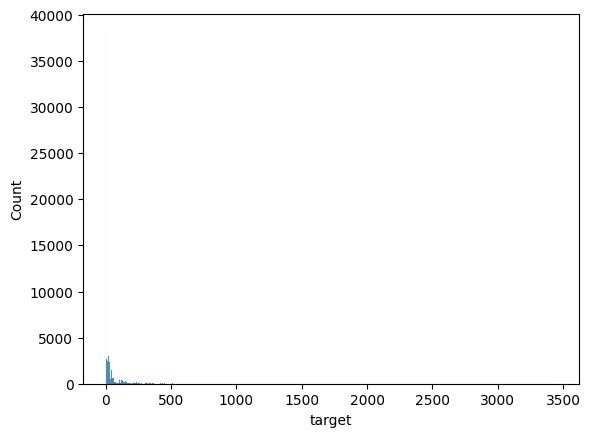

In [13]:
sns.histplot(flights, x="target")

In [14]:
flights.groupby("AC").target.mean().sort_values(ascending=False)

AC
OL 321ABY    205.400000
GJ 734CGC    167.705882
5K 345TFX    136.906542
GW 320MQH    126.147059
GJ 734MGC    121.693333
                ...    
TU CR9XXX      0.000000
UG AT7AT7      0.000000
UG CR9CR9      0.000000
UG CR9XXX      0.000000
TU 32A32A      0.000000
Name: target, Length: 68, dtype: float64

---

# Data Cleaning and Pre-Processing

In [15]:
# Wochentag (0 = Montag, 6 = Sonntag)
flights["weekday"] = flights["DATOP"].dt.weekday

# Monat (1 = Januar, 12 = Dezember)
flights["month"] = flights["DATOP"].dt.month

# Abflugstunde (Stunde aus geplanter Abflugzeit)
flights["dep_hour"] = flights["STD"].dt.hour

# Ankunftsstunde (Stunde aus geplanter Ankunftszeit)
flights["arr_hour"] = flights["STA"].dt.hour

# Geplante Flugdauer in Minuten
flights["scheduled_duration_min"] = (flights["STA"] - flights["STD"]).dt.total_seconds() / 60


In [16]:
## Spaltennamen bereinigen
flights.columns = (
    flights.columns
    .str.lower()
    .str.strip()
    .str.replace(" ", "_")
    .str.replace(r"[^\w]", "", regex=True)
)

## Leerzeichen am Anfang und Ende innerhalb der Spalte fltid entfernt
flights["fltid"] = flights["fltid"].str.strip()

In [17]:
flights = flights.drop("id", axis = 1)
flights.head()

,datop,fltid,depstn,dep_country,arrstn,arr_country,std,sta,status,ac,target,od,weekday,month,dep_hour,arr_hour,scheduled_duration_min
0,2016-01-03,TU 0712,CMN,Morocco,TUN,Tunisia,2016-01-03 10:30:00,2016-01-03 12:55:00,ATA,TU 32AIMN,260.0,CMN_TUN,6,1,10,12,145.0
1,2016-01-13,TU 0757,MXP,Italy,TUN,Tunisia,2016-01-13 15:05:00,2016-01-13 16:55:00,ATA,TU 31BIMO,20.0,MXP_TUN,2,1,15,16,110.0
2,2016-01-16,TU 0214,TUN,Tunisia,IST,Turkey,2016-01-16 04:10:00,2016-01-16 06:45:00,ATA,TU 32AIMN,0.0,TUN_IST,5,1,4,6,155.0
3,2016-01-17,TU 0480,DJE,Tunisia,NTE,France,2016-01-17 14:10:00,2016-01-17 17:00:00,ATA,TU 736IOK,0.0,DJE_NTE,6,1,14,17,170.0
4,2016-01-17,TU 0338,TUN,Tunisia,ALG,Algeria,2016-01-17 14:30:00,2016-01-17 15:50:00,ATA,TU 320IMU,22.0,TUN_ALG,6,1,14,15,80.0


## Fltid mapping (Yannek)

#### fltid Bedeutung:
- 0000: Route planning, repositioning, cargo, maintenance, test, etc.
- 1-99: Premium oder Langstreckenflüge
- 0100-0999: Interkontinental oder wichtige Flüge
- 1000-1299: Kurzstrecke u. Inland
- 3000-5999: Regionalflüge oder Tochtergesellschaften
- 6000+: Codeshare (durch andere Airline ausgeführt)
- 8000: Charter
- 9000: Positionierungsflüge

In [18]:
### Code here

# Save unique Flight IDs to CSV-file
# pd.DataFrame(flights['fltid'].unique().tolist()).to_csv('./data/Unique_fltids.csv')

# Use regular expressions to extract string components from fltid column
# Note: Requires import re` to work
flights['airline'] = flights['fltid'].str.extract(r'([A-Z]{2,3})')
flights['flt_type'] = flights['fltid'].str.extract(r'([0-9]{4})')

# Recode FLT_TYPE from number to string descriptor using regular expressions
flt_type_conditions = [
    flights['flt_type'].str.match(r'(^00[0-9]{2})$'),           # Match 0001-0099 'premium/ long haul'
    flights['flt_type'].str.match(r'(^0[1-9][0-9]{2}$)'),       # Match 0100-0999 'intercontinental'
    flights['flt_type'].str.match(r'(^1[0-2][0-9][0-9])'),      # Match 1000-1299 'domestic/ short haul'
    flights['flt_type'].str.match(r'(^[3-5][0-9][0-9][0-9])'),  # Match 3000-5999 'regional/ subsidiary'
    flights['flt_type'].str.match(r'(^[6-7][0-9][0-9][0-9])'),  # Match 6000-7999 'codeshare'
    flights['flt_type'].str.contains('8000'),                   # Match 8000 'charter'
    flights['flt_type'].str.contains('9000')                    # Match 9000 'positioning flight'
]

# Define string labels for flight type codes
flt_type_labels = ['premium/ long haul', 'intercontinental', 'domestic/ short haul',
                   'regional/ subsidiary', 'codeshare', 'charter', 'positioning flight']

# Replace numeric codes with string codes
flights['flt_type'] = np.select(flt_type_conditions, flt_type_labels, default='unknown')
flights['flt_type'] = flights['flt_type'].astype('category')
flights.head()

# RegEx Playground for testing expressions
# flights[flights['flt_type'].str.match(
# r'(^90{3})'                                                # Regular expression inside r'()'
# )].sort_values(by='flt_type').flt_type.unique()            # Sort unique FLT_TYPE values``

,datop,fltid,depstn,dep_country,arrstn,arr_country,std,sta,status,ac,target,od,weekday,month,dep_hour,arr_hour,scheduled_duration_min,airline,flt_type
0,2016-01-03,TU 0712,CMN,Morocco,TUN,Tunisia,2016-01-03 10:30:00,2016-01-03 12:55:00,ATA,TU 32AIMN,260.0,CMN_TUN,6,1,10,12,145.0,TU,intercontinental
1,2016-01-13,TU 0757,MXP,Italy,TUN,Tunisia,2016-01-13 15:05:00,2016-01-13 16:55:00,ATA,TU 31BIMO,20.0,MXP_TUN,2,1,15,16,110.0,TU,intercontinental
2,2016-01-16,TU 0214,TUN,Tunisia,IST,Turkey,2016-01-16 04:10:00,2016-01-16 06:45:00,ATA,TU 32AIMN,0.0,TUN_IST,5,1,4,6,155.0,TU,intercontinental
3,2016-01-17,TU 0480,DJE,Tunisia,NTE,France,2016-01-17 14:10:00,2016-01-17 17:00:00,ATA,TU 736IOK,0.0,DJE_NTE,6,1,14,17,170.0,TU,intercontinental
4,2016-01-17,TU 0338,TUN,Tunisia,ALG,Algeria,2016-01-17 14:30:00,2016-01-17 15:50:00,ATA,TU 320IMU,22.0,TUN_ALG,6,1,14,15,80.0,TU,intercontinental


In [19]:
flights.airline.fillna("unknown", inplace=True)

## Feature Engineering (Robert)

#### Zusätzliche Features engineeren (Morgen/Tag/Abend, Kalenderwochen, Werktag/Wochenende)

In [20]:
### Werktag oder Wochenende
flights["is_weekend"] = flights["weekday"].isin([5, 6]).astype(int)

In [21]:
### Kalenderwoche
flights["weekofyear"] = flights["datop"].dt.isocalendar().week

In [22]:
### Funktion für Daypart Definition
def get_daypart(hour):
    if 5 <= hour < 12:
        return "morning"
    elif 12 <= hour < 17:
        return "afternoon"
    elif 17 <= hour < 22:
        return "evening"
    else:
        return "night"

### Anwendung der Funktion
flights["daypart"] = flights["dep_hour"].apply(get_daypart)

In [23]:
## flitid die auf 0000 enden droppen
flights = flights[~flights['fltid'].str.endswith('0000')]

## fltid & ac droppen
flights = flights.drop(["fltid", "ac"], axis=1)

## Status = DEL droppen
flights = flights[flights["status"] != "DEL"]

In [24]:
flights.head()

,datop,depstn,dep_country,arrstn,arr_country,std,sta,status,target,od,weekday,month,dep_hour,arr_hour,scheduled_duration_min,airline,flt_type,is_weekend,weekofyear,daypart
0,2016-01-03,CMN,Morocco,TUN,Tunisia,2016-01-03 10:30:00,2016-01-03 12:55:00,ATA,260.0,CMN_TUN,6,1,10,12,145.0,TU,intercontinental,1,53,morning
1,2016-01-13,MXP,Italy,TUN,Tunisia,2016-01-13 15:05:00,2016-01-13 16:55:00,ATA,20.0,MXP_TUN,2,1,15,16,110.0,TU,intercontinental,0,2,afternoon
2,2016-01-16,TUN,Tunisia,IST,Turkey,2016-01-16 04:10:00,2016-01-16 06:45:00,ATA,0.0,TUN_IST,5,1,4,6,155.0,TU,intercontinental,1,2,night
3,2016-01-17,DJE,Tunisia,NTE,France,2016-01-17 14:10:00,2016-01-17 17:00:00,ATA,0.0,DJE_NTE,6,1,14,17,170.0,TU,intercontinental,1,2,afternoon
4,2016-01-17,TUN,Tunisia,ALG,Algeria,2016-01-17 14:30:00,2016-01-17 15:50:00,ATA,22.0,TUN_ALG,6,1,14,15,80.0,TU,intercontinental,1,2,afternoon


In [25]:
flights.info()

<class 'pandas.core.frame.DataFrame'>
Index: 102630 entries, 0 to 107832
Data columns (total 20 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   datop                   102630 non-null  datetime64[ns]
 1   depstn                  102630 non-null  object        
 2   dep_country             102630 non-null  object        
 3   arrstn                  102630 non-null  object        
 4   arr_country             102630 non-null  object        
 5   std                     102630 non-null  datetime64[ns]
 6   sta                     102630 non-null  datetime64[ns]
 7   status                  102630 non-null  object        
 8   target                  102630 non-null  float64       
 9   od                      102630 non-null  object        
 10  weekday                 102630 non-null  int32         
 11  month                   102630 non-null  int32         
 12  dep_hour                102630 non-

## Export of Cleaned Dataset

In [26]:
flights.to_csv('./data/flights_train_cleaned.csv', index=False)

---

# Modelling

## Baseline Model (Janina)

#### Mean pro Abflughafen (!!!Mean nur auf Train Daten berechnen!!!)

In [27]:
def baseline_model_mean_delay(flights, test_df, group_col='depstn', target_col='target'):
    """
    Baseline predictor: assigns the mean target value per group_col (e.g. DEPSTN) to each entry in test_df.
    """
    # Calculate mean delay per departure airport from training data
    group_mean = flights.groupby(group_col)[target_col].mean()

    # Predict for test set based on departure airport
    y_pred = test_df[group_col].map(group_mean)
    y_pred.fillna(flights[target_col].mean(), inplace=True)  # if DEPSTN in test but not in train: fill with global mean

    return y_pred

In [28]:
### Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RSEED)

NameError: name 'train_test_split' is not defined

In [ ]:
# Create predictions
flights_baseline = X_train.copy()
flights_baseline["target"] = y_train
test_df_baseline = X_test.copy()
test_df_baseline["target"] = y_test  # not used for prediction, but keeps interface consistent

y_pred_baseline = baseline_model_mean_delay(flights_baseline, test_df_baseline)

In [ ]:
# Evaluate RMSE & R2
rmse_baseline = np.sqrt(mean_squared_error(y_test, y_pred_baseline))
print((r2_score(y_test, y_pred_baseline)))
print(f" Baseline RMSE: {rmse_baseline:.2f} minutes")

0.019461487907789787
 Baseline RMSE: 119.02 minutes


## Model Comparison

In [ ]:
### Import Libraries
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, FunctionTransformer, OrdinalEncoder
from sklearn.ensemble import RandomForestRegressor
#from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np


In [ ]:
### X und y definieren
X = flights.drop("target", axis=1)
y = flights.target

In [ ]:
flights.info()

<class 'pandas.core.frame.DataFrame'>
Index: 102630 entries, 0 to 107832
Data columns (total 20 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   datop                   102630 non-null  datetime64[ns]
 1   depstn                  102630 non-null  object        
 2   dep_country             102630 non-null  object        
 3   arrstn                  102630 non-null  object        
 4   arr_country             102630 non-null  object        
 5   std                     102630 non-null  datetime64[ns]
 6   sta                     102630 non-null  datetime64[ns]
 7   status                  102630 non-null  object        
 8   target                  102630 non-null  float64       
 9   od                      102630 non-null  object        
 10  weekday                 102630 non-null  int32         
 11  month                   102630 non-null  int32         
 12  dep_hour                102630 non-

In [ ]:
### Spaltenarten für ColumnTransformer
numerical_features = ["weekday", "month", "dep_hour", "arr_hour", "scheduled_duration_min", "is_weekend", "weekofyear"]
categorical_features = ["depstn", "arrstn", "status", "daypart", "dep_country", "arr_country", "od", "airline", "flt_type"]

In [ ]:
### Preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ("num", "passthrough", numerical_features),
        ("cat", OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1), categorical_features)])

In [ ]:
# Random Forest Modell
rf_model = RandomForestRegressor(n_estimators=200, 
                               random_state=RSEED, 
                               max_features = 'sqrt',
                               n_jobs=-1, verbose = 1)

In [ ]:
### Pipeline
rf_pipeline = Pipeline(steps=[
    ("preprocessing", preprocessor),
    ("model", rf_model)
])

In [ ]:
### Trainieren & Bewerten

rf_pipeline.fit(X_train, y_train)
y_pred = rf_pipeline.predict(X_test)

# RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

# MAE
mae = mean_absolute_error(y_test, y_pred)

# R²
r2 = r2_score(y_test, y_pred)

print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"R2: {r2}")

n_nodes = []
max_depths = []

# Stats about the trees in random forest
# for ind_tree in rf_model.estimators_:
#     n_nodes.append(ind_tree.tree_.node_count)
#     max_depths.append(ind_tree.tree_.max_depth)
    
# print(f'Average number of nodes {int(np.mean(n_nodes))}')
# print(f'Average maximum depth {int(np.mean(max_depths))}')

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    2.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s


RMSE: 123.903734048509
MAE: 53.99645084566596
R2: -0.06261807305339184


[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:    0.3s finished


In [ ]:
### Feature importance
# The order of features after preprocessing is numerical_features + categorical_features
feature_names = numerical_features + categorical_features

fi_model = pd.DataFrame({
    'feature': feature_names,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

fi_model.head(20)

,feature,importance
6,weekofyear,0.291784
0,weekday,0.099327
1,month,0.089977
4,scheduled_duration_min,0.088756
13,od,0.069168
3,arr_hour,0.062147
2,dep_hour,0.061549
8,arrstn,0.044447
7,depstn,0.042132
15,flt_type,0.039707


In [ ]:
from sklearn.model_selection import RandomizedSearchCV

# ================================
# 1. Preprocessing (neue Namen)
# ================================
rf_preprocessor = ColumnTransformer([
    ("num", "passthrough", numerical_features),
    ("cat", OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1), categorical_features)
])

# ================================
# 2. Basismodell
# ================================
rf_base_model = RandomForestRegressor(random_state=42)

# ================================
# 3. Pipeline (separat benannt)
# ================================
rf_tuned_pipeline = Pipeline([
    ("rf_preprocessing", rf_preprocessor),
    ("rf_model", rf_base_model)
])

# ================================
# 4. Hyperparameter-Suchraum
# ================================
rf_param_grid = {
    "rf_model__n_estimators": np.arange(50, 201, 50),
    "rf_model__max_depth": [None, 5, 10, 20],
    "rf_model__min_samples_split": [2, 5, 10],
    "rf_model__max_features": ["sqrt", 0.7, 1.0]
}

# ================================
# 5. RandomizedSearchCV starten
# ================================
rf_random_search = RandomizedSearchCV(
    estimator=rf_tuned_pipeline,
    param_distributions=rf_param_grid,
    n_iter=10,
    cv=3,
    scoring="neg_root_mean_squared_error",
    n_jobs=-1,
    verbose=2,
    random_state=42
)

# ================================
# 6. Training starten
# ================================
rf_random_search.fit(X_train, y_train)

# ================================
# 7. Ergebnis auswerten
# ================================
print("Beste Parameter:", rf_random_search.best_params_)
print("Bester CV-RMSE:", -rf_random_search.best_score_)

# Optional: Vorhersage & finale Evaluation auf Validierungsset
y_pred_rf_tuned = rf_random_search.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_rf_tuned))
print(f"RMSE auf Validierungsdaten: {rmse:.2f} Minuten")


Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] END rf_model__max_depth=10, rf_model__max_features=sqrt, rf_model__min_samples_split=10, rf_model__n_estimators=150; total time=  10.0s
[CV] END rf_model__max_depth=20, rf_model__max_features=sqrt, rf_model__min_samples_split=10, rf_model__n_estimators=100; total time=  11.1s
[CV] END rf_model__max_depth=20, rf_model__max_features=sqrt, rf_model__min_samples_split=10, rf_model__n_estimators=100; total time=  11.2s
[CV] END rf_model__max_depth=20, rf_model__max_features=sqrt, rf_model__min_samples_split=10, rf_model__n_estimators=100; total time=  11.1s
[CV] END rf_model__max_depth=10, rf_model__max_features=sqrt, rf_model__min_samples_split=10, rf_model__n_estimators=150; total time=  10.5s
[CV] END rf_model__max_depth=5, rf_model__max_features=0.7, rf_model__min_samples_split=10, rf_model__n_estimators=50; total time=   6.1s
[CV] END rf_model__max_depth=10, rf_model__max_features=sqrt, rf_model__min_samples_split=10, rf

KeyboardInterrupt: 